# Identifying Dinosaurs with Deep Learning
My three year old son, like many his age, loves dinosaurs. As a result I am asked to name them on a regular basis as he tries to learn more and more about them. So naturally, while going through FastAI's [deep learning course](https://course.fast.ai/) one of the first applications that came to mind would be an app that could help me when I get stumped. Getting the dataset prepped took more work than anticipated, but the results were worth the effort.

For this notebook I used the approach covered in the first two lessons of the course. The general overview  is to use transfer learning to apply pre-trained models to new datasets and new labels. This allows a model to be trained to a high level of accuracy with less time and data.

To start, I used the code provided in the [lesson 2 notebook](https://www.kaggle.com/init27/fastai-v3-lesson-2) to download images from a google search, an approach credited to  [Adrian Rosebrock](https://www.pyimagesearch.com/2017/12/04/how-to-create-a-deep-learning-dataset-using-google-images/).

## The dataset
I chose 10 popular dinosaurs to test the approach.
* Tyrannosaurus rex
* Velociraptor
* Spinosaurus
* Triceratops
* Mosasaurus
* Stegosaurus
* Pterodactyl
* Brachiosaurus
* Allosaurus
* Apatosaurus

A few of the dinosaurs were chosen to give the model a challenge. Tyrannosaurus rex and allosaurus are very similar, as are brachiosaurus and apatosaurus.

One of the first difficulties I found was how innacurate the lables were when I relied on the raw results of google image searches. During initial attempts at building the model many of the classification mistakes were actually lable errors, prompting me to go through and manually curate the dataset.

Dinosaurs also presented a unique challenge. Unlike the pets from the example in [lesson 1](https://www.kaggle.com/hortonhearsafoo/fast-ai-v3-lesson-1) of the course, there really are no photographs of dinosaurs. Only artist depictions which, even when attempting to be scientifically accurate, leave a good deal to the artist's interpretation. And then there are the cartoons, toys and video games that make no attempt at accuracy.

This forced me to make some decisions. I needed to decide where to draw the line when screening images from my dataset. I settled on using a gut feel of whether or not I would be disappointed if the model was unable to classify the image. Fuzzy and disproportionate stuffed animals: out. Jurrasic park toys: in. Pink pterodactyls and yellow t-rexes: less clear. Anything too cartoonish had to go, but if it was at least close it stayed. This was admittedly not a scientific distinction, but it was an important step to take *before* training the model. To go back and cherry pick the images that it performed well on after training would be cheating and create a false sense of confidence in the model. The one exception was whether or not to include images of skeletons. In this case I decided to leave the pictures in out of curiousity, knowing that I likely take a different approach in a production model. For example, using a multiclassification model that had both dinosaur names as well as form (skeleton, normal, toy, etc.) as in [lesson 3](https://www.kaggle.com/hortonhearsafoo/fast-ai-v3-lesson-3-planet). But first I wanted to see if a simpler model would be able to generize well enough to distinguish their shapes in skeletal form. In total there were 1928 images in the dataset after I finished reviewing them.

In [1]:
# Setup basic imports
import pandas as pd
import numpy as np

from fastai.vision import *
from fastai import *
import os

In [2]:
# Setup the directory paths
input_root = Path('../input')
working = Path('../working')

Fastai attempts to store it's models in a directory relative to the images, but is unable to due to permission restrictions. There may be a way to change the model direcotry, but copying the images to the working directory provided a quick fix.

In [3]:
!cp -r ../input/images ../working/

Fastai provides a function for verifying images to avoid errors.

In [4]:
for sf in (working/'images').ls():
    verify_images(sf)

tuple index out of range


In [5]:
np.random.seed(42)
data = ImageDataBunch.from_folder(working, 'images', valid_pct=.2, bs=64,
                                  ds_tfms=get_transforms(), size=112).normalize(imagenet_stats)

In [6]:
data.classes

['allosaurus',
 'apatosaurus',
 'brachiosaurus',
 'mosasaurus',
 'pterodactyl',
 'spinosaurus',
 'stegosaurus',
 'triceratops',
 'tyrannosaurus',
 'velociraptor']

Looking at a few samples shows the range of images allowed into the dataset.

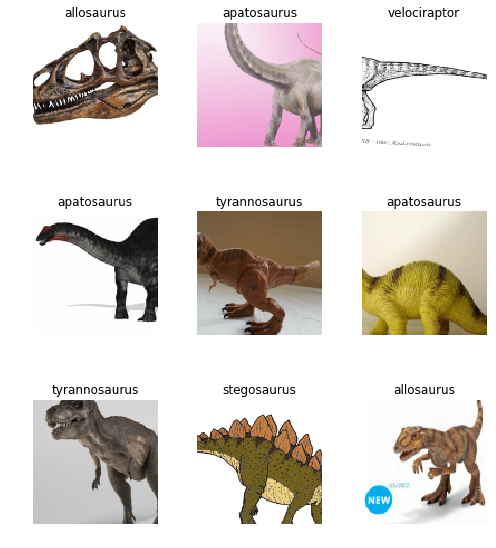

In [7]:
data.show_batch(rows=3, figsize=(7,8))

The first model I tested was created using the resnet34 architecture which was originally trained on the imagenet dataset.

In [8]:
learn = create_cnn(data, models.resnet34, metrics=[accuracy])

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /tmp/.torch/models/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:00<00:00, 87326227.39it/s]


After being created the initial layers of the model are frozen, and only the final layers which predict the classification are trained.

In [9]:
# run through 4 epochs of training
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,accuracy
1,2.481827,1.487124,0.496104
2,1.952047,1.222816,0.587013
3,1.636808,1.183291,0.620779
4,1.453568,1.172990,0.615584


In [10]:
# save progress
learn.save('stage-1')

Next all the layers are unfrozen, and the model is trained again. The lr_find function is used to tune the learning rate prior to training all the layers.

In [11]:
learn.unfreeze()

In [12]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


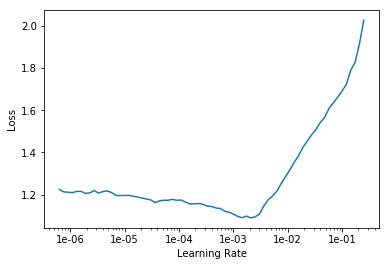

In [13]:
learn.recorder.plot()

In [14]:
learn.fit_one_cycle(8, max_lr=slice(1e-6,2e-3))

epoch,train_loss,valid_loss,accuracy
1,1.163784,1.132052,0.631169
2,1.124559,1.053583,0.631169
3,1.062294,1.003249,0.638961
4,0.938305,0.942423,0.675325
5,0.812394,0.948929,0.675325
6,0.713224,0.911894,0.688312
7,0.632215,0.894458,0.693506
8,0.572646,0.893656,0.683117


In [15]:
learn.save('stage-2')

71.9% accuracy is not bad, considering the variety of images I provided. But there is another step that can be done to improve results. The image dataset is recreated with larger images so that training can continue without overfitting.

In [16]:
# Recreate the databunch with 224x224 images. Batch size (bs) is reduced due to memory limitations
np.random.seed(42)
data = ImageDataBunch.from_folder(working, 'images', valid_pct=.2, bs=16,
                                  ds_tfms=get_transforms(), size=224).normalize(imagenet_stats)

In [17]:
learn = create_cnn(data, models.resnet34, metrics=accuracy)
learn.load('stage-2')

Learner(data=ImageDataBunch;

Train: LabelList
y: CategoryList (1541 items)
[Category brachiosaurus, Category brachiosaurus, Category brachiosaurus, Category brachiosaurus, Category brachiosaurus]...
Path: ../working
x: ImageItemList (1541 items)
[Image (3, 578, 700), Image (3, 1446, 1900), Image (3, 942, 942), Image (3, 720, 1280), Image (3, 942, 942)]...
Path: ../working;

Valid: LabelList
y: CategoryList (385 items)
[Category spinosaurus, Category triceratops, Category tyrannosaurus, Category apatosaurus, Category stegosaurus]...
Path: ../working
x: ImageItemList (385 items)
[Image (3, 600, 800), Image (3, 1410, 2127), Image (3, 321, 498), Image (3, 498, 800), Image (3, 642, 800)]...
Path: ../working;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stri

In [18]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,accuracy
1,0.792349,0.871896,0.722078
2,0.774701,0.876273,0.719481
3,0.704917,0.802999,0.737662
4,0.533709,0.783294,0.732468


The accuracy has already increased to 75.8% and we haven't even unfrozen the layers yet.

In [19]:
learn.save('stage-1-big')

In [20]:
learn.unfreeze()

In [21]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


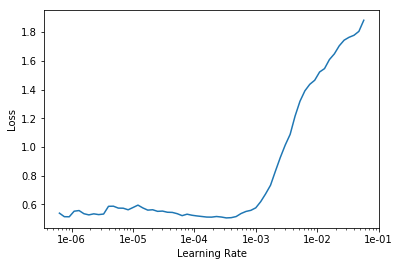

In [22]:
learn.recorder.plot()

In [23]:
learn.fit_one_cycle(8, max_lr=slice(1e-6, 3e-4))

epoch,train_loss,valid_loss,accuracy
1,0.516707,0.765255,0.729870
2,0.485544,0.732551,0.758442
3,0.491672,0.701870,0.784416
4,0.392256,0.707030,0.781818
5,0.369214,0.710238,0.768831
6,0.300636,0.677973,0.794805
7,0.278274,0.652005,0.805195
8,0.287227,0.656640,0.800000


In [24]:
learn.save('stage-2-big')

After training all of the layers the model was able to break 80% on the validation set. That's impressive for this task, but maybe we can do better. The same steps can be repeated again with pre-trained model with a larger architecture. Below I use the resnet50 model. 

In [25]:
np.random.seed(42)
data = ImageDataBunch.from_folder(working, 'images', valid_pct=.2, bs=64,
                                  ds_tfms=get_transforms(), size=112).normalize(imagenet_stats)

In [26]:
learn = create_cnn(data, models.resnet50, metrics=[accuracy])

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /tmp/.torch/models/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:01<00:00, 76304521.18it/s]


In [27]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,accuracy
1,2.200141,1.391344,0.553247
2,1.706038,1.157338,0.581818
3,1.402383,1.094101,0.610390
4,1.202109,1.080204,0.623377


In [28]:
learn.save('resnet50-stage-1')

In [29]:
learn.unfreeze()

In [30]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


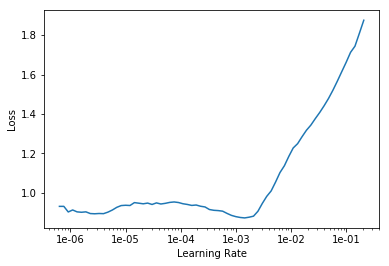

In [31]:
learn.recorder.plot()

In [32]:
learn.fit_one_cycle(8, max_lr=slice(1e-6, 1e-3))

epoch,train_loss,valid_loss,accuracy
1,0.973743,1.040085,0.649351
2,0.900658,0.987881,0.664935
3,0.837151,0.912924,0.701299
4,0.741277,0.893299,0.706493
5,0.655032,0.877841,0.724675
6,0.573307,0.864878,0.722078
7,0.512682,0.860931,0.727273
8,0.463142,0.862379,0.737662


In [33]:
learn.save('resnet50-stage-2')

In [34]:
np.random.seed(42)
data = ImageDataBunch.from_folder(working, 'images', valid_pct=.2, bs=8,
                                  ds_tfms=get_transforms(), size=224).normalize(imagenet_stats)

In [35]:
learn = create_cnn(data, models.resnet50, metrics=accuracy)
learn.load('resnet50-stage-2')

Learner(data=ImageDataBunch;

Train: LabelList
y: CategoryList (1541 items)
[Category brachiosaurus, Category brachiosaurus, Category brachiosaurus, Category brachiosaurus, Category brachiosaurus]...
Path: ../working
x: ImageItemList (1541 items)
[Image (3, 578, 700), Image (3, 1446, 1900), Image (3, 942, 942), Image (3, 720, 1280), Image (3, 942, 942)]...
Path: ../working;

Valid: LabelList
y: CategoryList (385 items)
[Category spinosaurus, Category triceratops, Category tyrannosaurus, Category apatosaurus, Category stegosaurus]...
Path: ../working
x: ImageItemList (385 items)
[Image (3, 600, 800), Image (3, 1410, 2127), Image (3, 321, 498), Image (3, 498, 800), Image (3, 642, 800)]...
Path: ../working;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stri

In [36]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,accuracy
1,1.038241,0.905000,0.690909
2,0.997095,0.817189,0.755844
3,0.771556,0.764522,0.761039
4,0.624556,0.760637,0.766234


In [37]:
learn.save('resnet50-stage-1-big')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


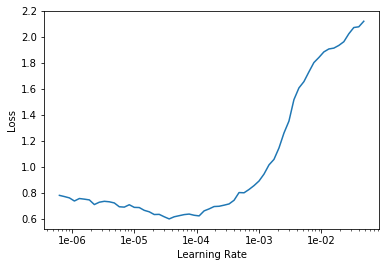

In [38]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [39]:
learn.fit_one_cycle(8, max_lr=slice(1e-5, 4e-4))

epoch,train_loss,valid_loss,accuracy
1,0.555019,0.708650,0.802597
2,0.733144,0.682433,0.776623
3,0.665416,0.749443,0.781818
4,0.557299,0.658266,0.802597
5,0.378407,0.628211,0.823377
6,0.368085,0.660981,0.815584
7,0.264776,0.634137,0.807792
8,0.241264,0.608078,0.823377


In [40]:
learn.save('resnet50-stage-2-big')

Here is where I've been running into difficulty. The results at this stage have varied between runs, from below 80 to as high as 87%. Whereas with resnet34 the accuracy has been more consistent.

In [41]:
interp = ClassificationInterpretation.from_learner(learn)

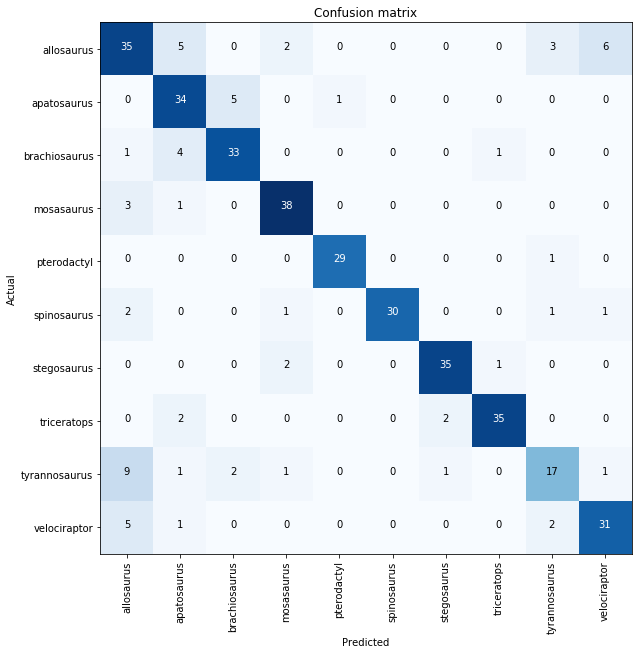

In [42]:
interp.plot_confusion_matrix(figsize=(9,9))

In [43]:
interp.most_confused(min_val=2)

[('tyrannosaurus', 'allosaurus', 9),
 ('allosaurus', 'velociraptor', 6),
 ('allosaurus', 'apatosaurus', 5),
 ('apatosaurus', 'brachiosaurus', 5),
 ('velociraptor', 'allosaurus', 5),
 ('brachiosaurus', 'apatosaurus', 4),
 ('allosaurus', 'tyrannosaurus', 3),
 ('mosasaurus', 'allosaurus', 3)]

As expected, the most common mistakes were between brachiosaurus and apatosaurus; and tyrannosaurus and allosaurus. The velociraptor also provided some difficulty with the allosaurus.

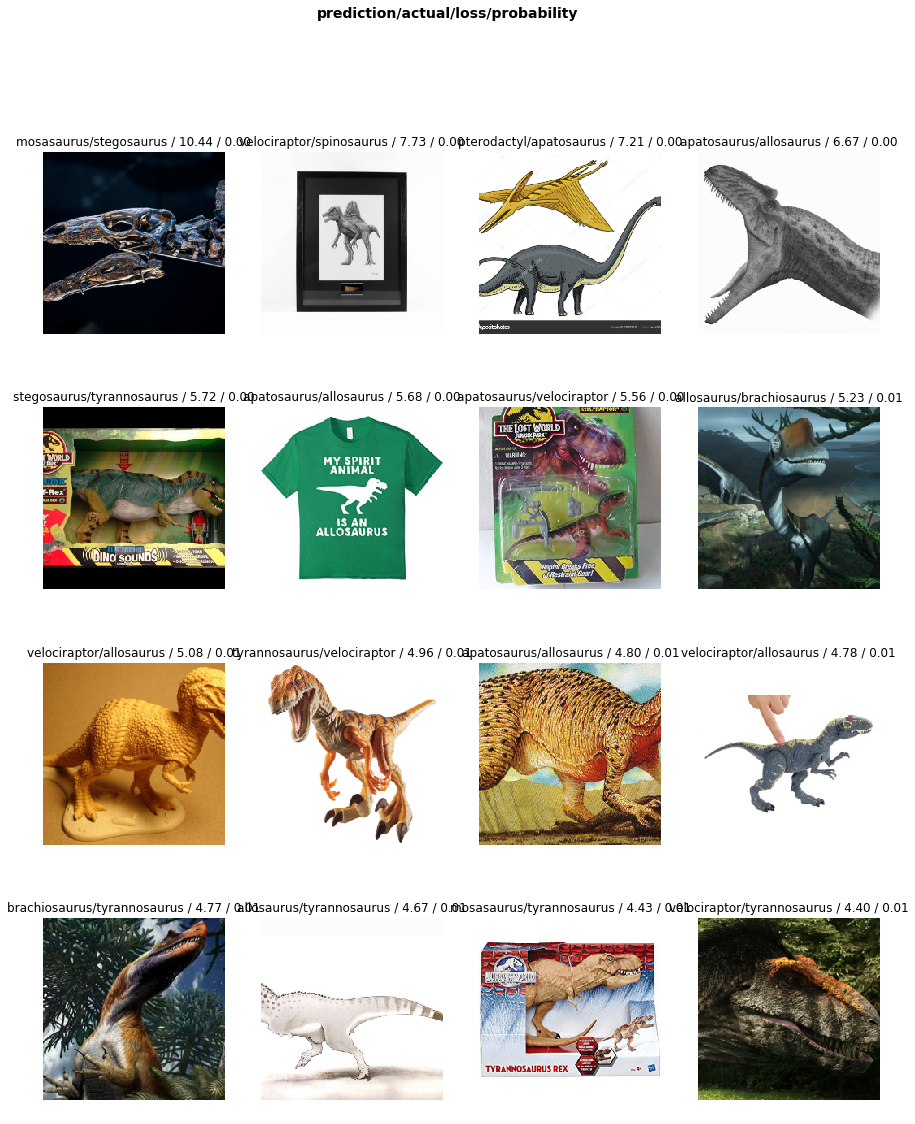

In [44]:
interp.plot_top_losses(16, figsize=(15,18))

Looking at the top losses revealed that there were still some issues with my labels. One picture, for example, does not appear at all to be a dinosaur I intended to have in the dataset. There are also a few with multiple dinosaurs that I missed.

In addition, it looks as though I have a number of mislabelled brachiosaurus/apatosaurus images. According to this answer by [Vincent Hill](https://www.quora.com/How-do-apatosaurus-and-brachiosaurus-differ) on quora, there is an easy way to distinguish the two dinosaurs that I wasn't aware of when I reviewed the images. Brachiosaurus had longer front legs and stood more upright and giraffe like. Whereas the apatosaurus had shorter front legs with a downward sloping neck. Based on that information several of the top losses look as though they were actually mislabelled, with one of them possibly showing both dinosaurs.

In [45]:
# kaggle limits output to 500 files, so the temporary images need to be deleted
# before commiting
for subdir in (working/'images').iterdir():
    for file in subdir.iterdir():
        os.remove(file)
    subdir.rmdir()